In [14]:
"""
List of Functions:
  timenow()
  show_file_contents(filename)
  prep_temperature_data()
  plot_temperature_timecourse(setpoint)
  """

import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import numpy
import os
from matplotlib import cm
matplotlib.rc('font', family='DejaVu Sans')

import warnings
warnings.filterwarnings("ignore", module="numpy")
warnings.filterwarnings("ignore", module="matplotlib")

plot_each_spectrum = False
plot_each_lissajous = False
plot_each_vi = False

plot_title = 'He jet, open loop, input step tests'
expname = '2016-07-06_06:39:25'
time_micro = '2016-07-06_06:39:27'
time_sys = '2016-07-06_06:39:35'

tmax = 13000
nom_v = 100
nom_f = 60
nom_q = 21

# absolute path to the main project folder
droot = os.path.abspath(os.path.join(os.sep,'mnt','storage'))
# relative paths to the directores we'll be using
ddata = os.path.join(droot,'data')
dexp = os.path.join(ddata,expname)
din = os.path.join(dexp,'in')
dout = os.path.join(dexp,'out')
dplot = os.path.join(dexp,'plot')
dbin = os.path.join(dexp,'bin')
dintemp = os.path.join(din, 'temperature')
dinthermo = os.path.join(din, 'thermograph')
dinosc = os.path.join(din, 'oscilloscope')
dinspectra = os.path.join(din, 'spectra')
dinintense = os.path.join(din, 'photointensity')
dincurrent = os.path.join(din, 'current')

# The experiment started at the folder timestamp
starttime = datetime.strptime(expname,"%Y-%m-%d_%H:%M:%S")
timepoint_micro = datetime.strptime(time_micro,"%Y-%m-%d_%H:%M:%S")
timepoint_system = datetime.strptime(time_sys,"%Y-%m-%d_%H:%M:%S")
# adjust the Arduino timestamps to match the system time (with a manual correction)
microtime_correction = timepoint_system - timepoint_micro - timedelta(seconds=1)

In [15]:
def timenow():
    print('The time now is: {:%Y-%m-%d_%H:%M:%S}'.format(datetime.now()))

def show_file_contents(filename):
    # show the user the results of the processing job
    print("Now processing data file: {:s}".format(filename))
    print("The contents of the file look like: ")
    with open(filename,'r') as myfile:
        for i in range(0,5):
            print('    {:s}'.format(myfile.readline()))

def prep_arduino_data():
    ### WORKS GOOD IN PYTHON3 (BC 2016-10-01)
    frawtemp = os.path.join(dintemp,os.listdir(dintemp)[0])
    fcleantemp = os.path.join(dout,'time_temperature.csv')
    fcleanset = os.path.join(dout,'time_setpoint.csv')
    
    # show the user information about the file being processed
    timenow()
    print("Building temperature timecourse...")
    show_file_contents(frawtemp) 
    
    ts2sec = lambda x: (datetime.strptime(x.decode(), '%Y-%m-%d_%H:%M:%S')-starttime+microtime_correction).total_seconds()
    col_types = [int,int,int,int,int,float,float,float,float,float,float]
    col_names = ['Time','Time_ms','Set_v_ad','Set_f_ad','Set_q_ad','Set_v','Set_f','Set_q','Tsurface','Ttube','Tcouple']
    dataset = numpy.genfromtxt(frawtemp,delimiter=',',invalid_raise=False,
                               usecols=[0,1,5,6,7,8,9],skip_header=60,
                               dtype=col_types,names=col_names,converters={'Time':ts2sec})
    time_us=[]
    # correcting the timestamps for millisecond resolution
    now_seconds = 0
    prev_seconds = 0
    now_ms = 0
    prev_ms = 0
    ts_ms = 0
    for line in dataset:
        now_seconds = line[0]
        now_ms = line[1]
        if now_seconds != prev_seconds:
            prev_seconds = now_seconds
            prev_ms = now_ms
            ts_ms = 0
        else:
            ts_ms = prev_ms + (now_ms - prev_ms) % 1000
            prev_ms = ts_ms
        time_us.append(now_seconds + ts_ms/1000)
    # reshape and combine the array - time
    time_reshaped = numpy.reshape(time_us,(len(time_us),1))
    
    # reshape and combine the arrays - time / temperature
    tsurface_reshaped = numpy.reshape(dataset['Tsurface'],(len(dataset['Tsurface']),1))
    ttube_reshaped = numpy.reshape(dataset['Ttube'],(len(dataset['Ttube']),1))
    dataset_clean = numpy.concatenate((time_reshaped,tsurface_reshaped,ttube_reshaped),axis=1)
    # save to file - time / temperature
    numpy.savetxt(fcleantemp,dataset_clean,fmt='%f,%f,%f')
    # show the user the results of the processing job - time / temperature
    show_file_contents(fcleantemp)
    timenow()
    print("Temperature timecourse complete!\n\n")
    
    # reshape and combine the arrays - time / setpoint
    print("Building setpoint timecourse...")
    set_v_reshaped = numpy.reshape(dataset['Set_v'],(len(dataset['Set_v']),1))
    set_f_reshaped = numpy.reshape(dataset['Set_f'],(len(dataset['Set_f']),1))
    set_q_reshaped = numpy.reshape(dataset['Set_q'],(len(dataset['Set_q']),1))
    dataset_clean = numpy.concatenate((time_reshaped,set_v_reshaped,set_f_reshaped,set_q_reshaped),axis=1)
    # save to file
    numpy.savetxt(fcleanset,dataset_clean,fmt='%f,%f,%f,%f')
    # show the user the results of the processing job
    show_file_contents(fcleanset)
    timenow()
    print("Setpoint timecourse complete!\n")
    print("#######################\n")
    print("#######################\n\n")
    

def plot_temperature_timecourse(setpoint=None):
    ### THIS FUNCTION WORKS (BC 2016-10-01)
    fcleantemp = os.path.join(dout,'time_temperature.csv')
    # show the user the results of the processing job
    timenow()
    print('Plotting temperature data!')
    show_file_contents(fcleantemp)
    ##############################################
    ### IMPORTING THE DATA INTO xax, yax1, yax2
    ##############################################
    col_headers = ['Time','Tsurface','Ttube']
    col_types = (float,float,float)
    dataset = numpy.genfromtxt(fcleantemp,delimiter=',',
                               names=col_headers,
                               dtype=col_types)
    ##############################################
    ### PLOTTING THE DATA
    ##############################################
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dataset['Time'],dataset['Tsurface'],label='Tsurface',
            linestyle='None',marker='o',markersize=1,color='red',markeredgecolor='red')
    ax.plot(dataset['Time'],dataset['Ttube'],label='Ttube',
            linestyle='None',marker='o',markersize=1,color='blue',markeredgecolor='blue',)
    if setpoint is not None:
        ax.axhline(setpoint,0,xax[-1],color='black',linestyle='--')
    ax.set_ylim([15,40])
    ax.set_xlim([0,13000])
    plt.title('He jet, PID @ 40C, 0.5 slpm, 10 kHz')
    ax.set_xlabel('runtime, seconds')
    ax.set_ylabel('temperature, degC')
    ax.legend(loc=0,markerscale=8)
    ax.grid(True)
    # save the plot to a file
    fplot = os.path.join(dplot,'temperature_history.png')
    fig.savefig(fplot,dpi=150)
    timenow()
    print('Temperature timecourse saved to {:s}'.format(fplot))
    print("#######################\n")
    print("#######################\n\n")
    plt.close(fig)

def plot_setpoint_timecourse(setpoint=None):
    ### THIS FUNCTION WORKS (BC 2016-10-01)
    fcleanset = os.path.join(dout,'time_setpoint.csv')
    # show the user the results of the processing job
    timenow()
    print("Plotting setpoint data!")
    show_file_contents(fcleanset)
    ##############################################
    ### IMPORTING THE DATA INTO `dataset
    ##############################################
    col_headers = ['Time','Set_v','Set_f','Set_q']
    col_types = (float,float,float,float)
    dataset = numpy.genfromtxt(fcleanset,delimiter=',',
                               names=col_headers,
                               dtype=col_types)
    ##############################################
    ### PLOTTING THE DATA
    ##############################################
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dataset['Time'],dataset['Set_v'],label='Set_v',
            linestyle='None',marker='o',markersize=1,color='red',markeredgecolor='red')
    ax.plot(dataset['Time'],dataset['Set_f'],label='Set_f',
            linestyle='None',marker='o',markersize=1,color='blue',markeredgecolor='blue',)
    ax.plot(dataset['Time'],dataset['Set_q'],label='Set_q',
            linestyle='None',marker='o',markersize=1,color='green',markeredgecolor='green',)
    if setpoint is not None:
        ax.axhline(setpoint,0,xax[-1],color='black',linestyle='--')
    ax.set_ylim([0,100])
    ax.set_xlim([0,13000])
    plt.title('He jet, PID @ 40C, 0.5 slpm, 10 kHz')
    ax.set_xlabel('runtime, seconds')
    ax.set_ylabel('setpoint, %')
    ax.legend(loc=0,markerscale=8)
    ax.grid(True)
    # save the plot to a file
    fplot = os.path.join(dplot,'setpoint_history.png')
    fig.savefig(fplot,dpi=150)
    timenow()
    print('Setpoint timecourse saved to {:s}'.format(fplot))
    print("#######################\n")
    print("#######################\n\n")
    plt.close(fig)

def prep_power_data():
    """Prepares .csv files containing the time-power and voltage-power relationships"""
    ### THIS WORKS (BC 2016-10-01)
    timenow()
    print("Prepping power data...")
    fcleanpower = os.path.join(dout,'time_power.csv')
    fcleanpowervoltage = os.path.join(dout,'voltage_power.csv')
    fcleanfreq = os.path.join(dout,'time_frequency.csv')
    
    freqtime = []
    powertime = []
    powervoltage = []
    
    # get the list of files in the oscilloscope directory
    files = sorted(os.listdir(dinosc))
    
    # for each of the oscilloscope traces..
    for f in files:
        filename = os.path.join(dinosc,f)
        # use the filename to get the time the datapoint was taken (relative to starttime)
        t = (datetime.strptime(f,"%Y-%m-%d_%H:%M:%S")-starttime).total_seconds()
        
        if (t > tmax):
                break
        
        # import the data in this file (time, channels 1-4)
        data = numpy.genfromtxt(filename,delimiter=',')
        xax = [line[0] for line in data]
        data_v = [line[1] for line in data]
        data_vcap = [line[2] for line in data]
        data_i = [line[3] for line in data]
        
        # grab the peak-to-peak voltage directly from the data
        voltage = max(data_v)-min(data_v)
        
        # calculate the frequency from the oscilloscope trace
        frequency = get_frequency(xax,data_v)
        
        # calculate the power from Vapp and Vcap using the Lissajous method
        power = get_power(vapp=data_v,vcap=data_vcap,title=str(voltage).split('.')[0])
        
        
        # save the time-power and voltage-power relationships to an array
        freqtime.append((t,frequency))
        powertime.append((t,power))
        powervoltage.append((voltage,power))
        
        if plot_each_vi:
            ##############################################
            ### PLOTTING THE DATA
            ##############################################
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(xax,data_v,
                    linestyle='None',marker='o',markersize=1,color='red',markeredgecolor='red')
            #ax.set_ylim([15,40])
            #ax.set_xlim([0,13000])
            plt.title(plot_title)
            ax.set_xlabel('time,seconds')
            ax.set_ylabel('voltage, kilovolts')
            #ax.legend(loc=0,markerscale=8)
            ax.grid(True)
            # save the plot to a file
            fplot = os.path.join(dplot,'vi','vi_{}.png'.format(f))
            fig.savefig(fplot,dpi=150)
            plt.close(fig)
    
    # save the time-power and voltage-power relationships to a file
    numpy.savetxt(fcleanpower,powertime,fmt='%f,%f')
    numpy.savetxt(fcleanpowervoltage,powervoltage,fmt='%f,%f')
    numpy.savetxt(fcleanfreq,freqtime,fmt='%f,%f')
    
    # show the user the results of the processing job
    show_file_contents(fcleanpower)
    timenow()
    print("Power timecourse complete!\n\n")
    show_file_contents(fcleanpowervoltage)
    timenow()
    print("Power-voltage complete!\n")
    print("#######################\n")
    print("#######################\n\n")

def get_power(vapp,vcap,title):
    """Calculates the power, given the applied and Lissajous capacitor voltages"""
    vcap_value = 0.47 # 0.47 = 47nF 
    # iff >1, apply a window smoothing function to the voltage data
    windowSize = 1
    Liss = create_lissajous(Vapp=vapp,Vcap=vcap,window=windowSize)
    
    # find the area enclosed by the Lissajous figure of the first 1000 datapoints
    area = find_area(Liss[0:1000])
    # wattage is proportional to the area, the Lissajous cap size, sample duration (0.001s)
    watts = int(str(area).split('.')[0])*vcap_value/1000.
    
    # if specified in the header, plot each lissajous figure
    if plot_each_lissajous:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot([p[0] for p in Liss],[p[1] for p in Liss],linestyle='-',marker='o',markersize=3,markeredgewidth=0)
        plt.title('The area of the Lissajous figure is: ' + str(area))
        ax.set_xlabel('volts, applied')
        ax.set_ylabel('volts, capacitor')
        fname = title + '_pwr' + str(area).split('.')[0] + '.png'
        fsave = os.path.join(dplot,'lissajous',fname)
        plt.savefig(fsave,dpi=150)
        plt.close(fig)
        
    # return the wattage measured at this timepoint
    return(watts)

def create_lissajous(Vapp,Vcap,window=1):
    """Generates a Lissajous figure from the applied and capacitor voltage oscilloscope traces."""
    #x=[Vapp[i][1] for i in range(0,len(Vapp))] # if your data also includes time
    #y=[Vcap[i][1] for i in range(0,len(Vcap))]
    x = Vapp
    y = Vcap
    if window!= 1:
        x = moving_average(x,window)
        y = moving_average(y,window)
    Liss = []
    for i in range(0,len(Vapp)):
        Liss.append((x[i],y[i]))
    return Liss

def moving_average(interval, window_size):
    """Finds the moving average of a dataset over a window size."""
    # algorithm via http://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

def find_area(array):
    """Find the array of a polygon defined as a set of Cartesian points in an array."""
    # algorithm via http://www.arachnoid.com/area_irregular_polygon/index.html
    a = 0
    ox,oy = array[0]
    for x,y in array[1:]:
        a += (x*oy-y*ox)
        ox,oy = x,y
    return abs(a/2)

def prep_power_setpoint():
    fcleanpower = os.path.join(dout,'time_power.csv') 
    fcleanset = os.path.join(dout,'time_setpoint.csv')
    fcleanpowerset = os.path.join(dout,'power_setpoint.csv')
    
    timenow()
    print("Determining power-setpoint relationships...")
    
    col_headers = ['Time','Power']
    col_types = [float,float]
    time_power = numpy.genfromtxt(fcleanpower,delimiter=',',
                                  names=col_headers,
                                  dtype=col_types)
    timenow()
    print("Time-power data loaded!")
    
    col_headers = ['Time','Set_v','Set_f','Set_q']
    col_types = (float,float,float,float)
    time_setpoint = numpy.genfromtxt(fcleanset,delimiter=',',
                                     names=col_headers,
                                     dtype=col_types)
    timenow()
    print("Time-setpoint data loaded!")
    
    power_setpoint = []
    with open(fcleanpowerset,'w') as myfile:
        for line in time_power:
            t = 0
            if (t > tmax):
                break
            t = line[0]
            p = line[1]
            set_v = numpy.interp(t,time_setpoint['Time'],time_setpoint['Set_v'])
            set_f = numpy.interp(t,time_setpoint['Time'],time_setpoint['Set_f'])
            set_q = numpy.interp(t,time_setpoint['Time'],time_setpoint['Set_q'])
            
            #power_setpoint.append((p,set_v,set_f,set_q))
            myfile.write('{:f},{:f},{:f},{:f},{:f}\n'.format(t,p,set_v,set_f,set_q))
    
    ## save the power-setpoint relationships to a file
    ## estimated time to completion with full dataset: ~40 minutes
    #numpy.savetxt(fcleanpowerset,power_setpoint,fmt='%f,%f,%f,%f')
    
    # show the user the results of the processing job
    show_file_contents(fcleanpowerset)
    timenow()
    print("Power-Setpoint .csv complete!\n")
    print("#######################\n")
    print("#######################\n\n")

def plot_power_setpoint(var='Set_v'):
    ### TESTING (BC 2016-10-01)
    fcleanpowerset = os.path.join(dout,'power_setpoint.csv')
    # show the user the results of the processing job
    timenow()
    print('Plotting power-setup data!')
    show_file_contents(fcleanpowerset)
    ##############################################
    ### IMPORTING THE DATA INTO `dataset`
    ##############################################
    col_headers = ['Time','Power','Set_v','Set_f','Set_q']
    col_types = (float,float,float,float,float)
    dataset = numpy.genfromtxt(fcleanpowerset,delimiter=',',
                               names=col_headers,
                               dtype=col_types)
    ##############################################
    ### PLOTTING THE DATA
    ##############################################
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dataset[var],dataset['Power'],label='Power',
            linestyle='None',marker='o',markersize=1,color='red',markeredgecolor='red')
    #ax.set_ylim([15,40])
    #ax.set_xlim([0,13000])
    plt.title('He jet, PID @ 40C, 0.5 slpm, 10 kHz')
    ax.set_xlabel(var)
    ax.set_ylabel('Power, W')
    ax.legend(loc=0,markerscale=8)
    ax.grid(True)
    # save the plot to a file
    fplot = os.path.join(dplot,'{:s}-power.png'.format(var))
    fig.savefig(fplot,dpi=150)
    timenow()
    print('{:s} timecourse saved to {:s}'.format(var,fplot))
    print("#######################\n")
    print("#######################\n\n")
    plt.close(fig)

def plot_power_setpoint_subset(xvar='Set_q',varied='Set_v',fixed='Set_f',fixedval=60):
    ### TESTING (BC 2016-10-01)
    fcleanpowerset = os.path.join(dout,'power_setpoint.csv')
    # show the user the results of the processing job
    timenow()
    print('Plotting power-setpoint data!')
    show_file_contents(fcleanpowerset)
    ##############################################
    ### IMPORTING THE DATA INTO `dataset`
    ##############################################
    col_headers = ['Time','Power','Set_v','Set_f','Set_q']
    col_types = (float,float,float,float,float)
    dataset = numpy.genfromtxt(fcleanpowerset,delimiter=',',
                               names=col_headers,
                               dtype=col_types)
    t_index = 0
    p_index = 1
    q_index = 4
    v_index = 2
    f_index = 3
    q_vals = [3,5,7,9,11,13,15,17,19,21,23,25]
    v_vals = [40,45,50,55,60,65,70,75,80,85,90,95,100]
    f_vals = [0,10,20,30,40,50,60]
    
    if xvar == 'Set_q':
        xvar_index = q_index
        xvals = q_vals
    elif xvar == 'Set_v':
        xvar_index = v_index
        xvals = v_vals
    elif xvar == 'Set_f':
        xvar_index = f_index
        xvals = f_vals
    
    if varied == 'Set_q':
        varied_index = q_index
        varied_vals = q_vals
    elif varied == 'Set_v':
        varied_index = v_index
        varied_vals = v_vals
    elif varied == 'Set_f':
        varied_index = f_index
        varied_vals = f_vals
    
    if fixed =='Set_q':
        fixed_index = q_index
        fixed_vals = q_vals
    elif fixed =='Set_v':
        fixed_index = v_index
        fixed_vals = v_vals
    elif fixed =='Set_f':
        fixed_index = f_index
        fixed_vals = f_vals
    
    ##############################################
    ### PLOTTING THE DATA
    ##############################################
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # colormap stuff
    cm_start = 0.0
    cm_stop = 1.0
    cm_numlines= len(varied_vals)
    colors = [ cm.viridis(x) for x in numpy.linspace(cm_start, cm_stop, cm_numlines) ]
    
    # plot particular series!
    for num,varied_val in enumerate(varied_vals):
        myX = []
        myY = []
        for line in dataset:
            if (line[varied_index] == varied_val) and (line[fixed_index] == fixedval):
                myX.append(line[xvar_index])
                myY.append(line[p_index])
        # plot this set!
        ax.plot(myX,myY,label='{}={}'.format(varied,varied_val),color=colors[num],
            linestyle='None',marker='o',markersize=5,markeredgewidth=0)
    #ax.set_ylim([15,40])
    #ax.set_xlim([0,13000])
    plt.title('He jet, PID @ 40C, 0.5 slpm, 10 kHz')
    ax.set_xlabel(xvar)
    ax.set_ylabel('Power, W')
    ax.legend(loc=0,markerscale=1.5,fontsize=8,numpoints=3,ncol=2)
    ax.grid(True)
    # save the plot to a file
    fplot = os.path.join(dplot,'{:s}-power_varied_{:s}.png'.format(xvar,varied))
    fig.savefig(fplot,dpi=150)
    timenow()
    print('{:s} timecourse saved to {:s}'.format(xvar,fplot))
    print("#######################\n")
    print("#######################\n\n")
    plt.close(fig)

In [16]:
def get_frequency(xset,yset):
    zerocross=[]
    ymax = max(yset)
    ymin = min(yset)
    ymid = (ymax+ymin)/2
    for i in range(2,len(yset)-2):
        if (yset[i] >= ymid) and (yset[i+1] >= ymid) and (yset[i-1] <= ymid) and (yset[i-2] <= ymid):
            thiscross = xset[i]
            zerocross.append(thiscross)
            #print('crossing between indexes {} and {}'.format(i, i+1))
        elif (yset[i] <= ymid) and (yset[i+1] <= ymid) and (yset[i-1] >= ymid) and (yset[i-2] >= ymid):
            thiscross = xset[i]
            zerocross.append(thiscross)
            #print('crossing between indexes {} and {}'.format(i, i+1))
    zerointerval=[]
    for i in range(1,len(zerocross)):
        zerointerval.append(zerocross[i]-zerocross[i-1])
    return (2 / numpy.mean(zerointerval))

def prep_freq_setpoint():
    fcleanfreq = os.path.join(dout,'time_frequency.csv') 
    fcleanset = os.path.join(dout,'time_setpoint.csv')
    fcleanfreqset = os.path.join(dout,'freq_setpoint.csv')
    
    timenow()
    print("Determining frequency-setpoint relationships...")
    
    col_headers = ['Time','Frequency']
    col_types = [float,float]
    time_freq = numpy.genfromtxt(fcleanfreq,delimiter=',',
                                  names=col_headers,
                                  dtype=col_types)
    timenow()
    print("Time-frequency data loaded!")
    
    col_headers = ['Time','Set_v','Set_f','Set_q']
    col_types = (float,float,float,float)
    time_setpoint = numpy.genfromtxt(fcleanset,delimiter=',',
                                     names=col_headers,
                                     dtype=col_types)
    timenow()
    print("Time-setpoint data loaded!")
    
    freq_setpoint = []
    with open(fcleanfreqset,'w') as myfile:
        for line in time_freq:
            t = 0
            if (t > tmax):
                break
            t = line[0]
            f = line[1]
            set_v = numpy.interp(t,time_setpoint['Time'],time_setpoint['Set_v'])
            set_f = numpy.interp(t,time_setpoint['Time'],time_setpoint['Set_f'])
            set_q = numpy.interp(t,time_setpoint['Time'],time_setpoint['Set_q'])
            
            #power_setpoint.append((p,set_v,set_f,set_q))
            myfile.write('{:f},{:f},{:f},{:f},{:f}\n'.format(t,f,set_v,set_f,set_q))
    
    ## save the power-setpoint relationships to a file
    ## estimated time to completion with full dataset: ~40 minutes
    #numpy.savetxt(fcleanpowerset,power_setpoint,fmt='%f,%f,%f,%f')
    
    # show the user the results of the processing job
    show_file_contents(fcleanfreqset)
    timenow()
    print("Frequency-Setpoint .csv complete!\n")
    print("#######################\n")
    print("#######################\n\n")

def plot_freq_setpoint():
    ### TESTING (BC 2016-10-01)
    fcleanfreqset = os.path.join(dout,'freq_setpoint.csv')
    # show the user the results of the processing job
    timenow()
    print('Plotting frequency-setpoint data!')
    show_file_contents(fcleanfreqset)
    ##############################################
    ### IMPORTING THE DATA INTO `dataset`
    ##############################################
    col_headers = ['Time','Frequency','Set_v','Set_f','Set_q']
    col_types = (float,float,float,float,float)
    dataset = numpy.genfromtxt(fcleanfreqset,delimiter=',',
                               names=col_headers,
                               dtype=col_types)
    t_index = 0
    f_index = 1
    q_index = 4
    v_index = 2
    setf_index = 3

    f_vals = [0,10,20,30,40,50,60]
    xvar = 'Set_f'
    xvar_index = setf_index
    xvals = f_vals
    varied_vals = f_vals
    
    ##############################################
    ### PLOTTING THE DATA
    ##############################################
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # colormap stuff
    cm_start = 0.0
    cm_stop = 1.0
    cm_numlines= len(f_vals)
    colors = [ cm.viridis(x) for x in numpy.linspace(cm_start, cm_stop, cm_numlines) ]
    
    # plot particular series!
    for num,varied_val in enumerate(varied_vals):
        myX = []
        myY = []
        for line in dataset:
            myX.append(line[xvar_index])
            myY.append(line[f_index])
        # plot this set!
        ax.plot(myX,myY,color=colors[num],
            linestyle='None',marker='o',markersize=5,markeredgewidth=0)
    #ax.set_ylim([15,40])
    #ax.set_xlim([0,13000])
    plt.title('He jet, PID @ 40C, 0.5 slpm, 10 kHz')
    ax.set_xlabel(xvar)
    ax.set_ylabel('Frequency, f')
    ax.legend(loc=0,markerscale=1.5,fontsize=8,numpoints=3,ncol=2)
    ax.grid(True)
    # save the plot to a file
    fplot = os.path.join(dplot,'{:s}-freq.png'.format(xvar))
    fig.savefig(fplot,dpi=150)
    timenow()
    print('{:s} timecourse saved to {:s}'.format(xvar,fplot))
    print("#######################\n")
    print("#######################\n\n")
    plt.close(fig)

In [4]:
prep_arduino_data()
plot_temperature_timecourse()
plot_setpoint_timecourse()
prep_power_data()
prep_power_setpoint()
prep_freq_setpoint()
plot_power_setpoint('Set_v')
plot_power_setpoint('Set_f')
plot_power_setpoint('Set_q')
plot_power_setpoint_subset(xvar='Set_q',varied='Set_v',fixed='Set_f',fixedval=nom_f)
plot_power_setpoint_subset(xvar='Set_q',varied='Set_f',fixed='Set_v',fixedval=nom_v)
plot_power_setpoint_subset(xvar='Set_f',varied='Set_v',fixed='Set_q',fixedval=nom_q)
plot_power_setpoint_subset(xvar='Set_f',varied='Set_q',fixed='Set_v',fixedval=nom_v)
plot_power_setpoint_subset(xvar='Set_v',varied='Set_q',fixed='Set_f',fixedval=nom_f)
plot_power_setpoint_subset(xvar='Set_v',varied='Set_f',fixed='Set_q',fixedval=nom_q)
plot_freq_setpoint()

The time now is: 2016-10-04_21:45:05
Building temperature timecourse...
Now processing data file: /mnt/storage/data/2016-07-06_06:39:25/in/temperature/temperaturehistory
The contents of the file look like: 
    :39:27,421,368,469,3,40.00,0.00,0.00,23.56,23.60,0.00

    2016-07-046-07-06_06:39:27,022,368,467,3,40.00,0.00,0.00,23.90,23.34,0.00

    2016-07-06_06:39:27,033,368,400,0.00,0.00,23.90,23.34,0.00

    2016-07-06_06:39:27,022,368,467,3,40.00,0.00,0.00,23.90,23.34,0.00

    2016-07-06_06:39:27,033,368,468,2,40.00,0.00,0.00,23.90,23.34,0.00

Now processing data file: /mnt/storage/data/2016-07-06_06:39:25/out/time_temperature.csv
The contents of the file look like: 
    10.000000,23.660000,23.560000

    10.692000,23.660000,23.560000

    10.704000,23.660000,23.560000

    10.715000,23.380000,23.560000

    10.727000,23.380000,23.560000

The time now is: 2016-10-04_21:46:33
Temperature timecourse complete!


Building setpoint timecourse...
Now processing data file: /mnt/storage/dat

In [17]:
prep_power_data()

The time now is: 2016-10-04_22:45:27
Prepping power data...
Now processing data file: /mnt/storage/data/2016-07-06_06:39:25/out/time_power.csv
The contents of the file look like: 
    10.000000,0.028200

    11.000000,0.049350

    13.000000,0.027260

    14.000000,0.032430

    16.000000,0.050290

The time now is: 2016-10-04_22:46:41
Power timecourse complete!


Now processing data file: /mnt/storage/data/2016-07-06_06:39:25/out/voltage_power.csv
The contents of the file look like: 
    2960.000000,0.028200

    2960.000000,0.049350

    2960.000000,0.027260

    3360.000000,0.032430

    3360.000000,0.050290

The time now is: 2016-10-04_22:46:41
Power-voltage complete!

#######################

#######################




In [372]:
### THIS WORKS, but it's kinda guesswork on the guess_vals
from scipy import optimize

def get_freq_fit(myfile,doplot=False):
    data = numpy.genfromtxt(myfile,delimiter=',',usecols=(0,1),
                                names=('Time','Vapp','Vcap','I'),
                            dtype=(float,float,float,float),
                           converters={'Time':s2ms})
    mymodel = lambda p,x: p[0]*numpy.sin(p[1]*x + p[2])
    mymodelerr = lambda p,x,y: mymodel(p,x)-y
    guess_vals = [3000.,50.,0.]

    best_vals, covar = optimize.leastsq(mymodelerr, guess_vals[:], args=(data['Time'], data['Vapp']))

    #print(best_vals)
    #print(covar)
    if doplot:
        xmin = data['Time'].min()
        xmax = data['Time'].max()
        xsteps = 100
        x = numpy.linspace(xmin,xmax,xsteps)
        plt.plot(data['Time'],data['Vapp'],linestyle='None',marker='o',markersize=3,markeredgewidth=0,color='blue')
        plt.plot(x,mymodel(best_vals[:],x),color='green',linestyle='-',markersize=0)
        plt.show()
    return 1000*best_vals[1]/(2*numpy.pi)

f = os.path.join(dinosc,'2016-07-06_06:39:44')
%timeit get_freq_fit(f)

100 loops, best of 3: 8.89 ms per loop


[ -3.91151509e+02   2.77900824e+01  -6.41279570e-02]
[[  2.09330986e+03   2.27399976e+00   6.51960306e-02]
 [  2.27399976e+00   5.64128177e-01  -2.59113638e-04]
 [  6.51960306e-02  -2.59113638e-04   1.48593153e-02]]


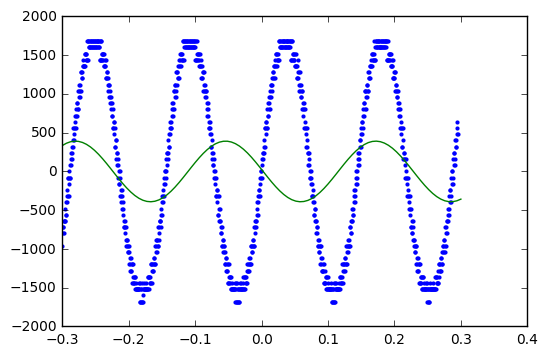

In [253]:
### THIS DOESN'T WORK and generally sucks
from scipy.optimize import curve_fit
s2ms = lambda x: float(x)*1000

f = os.path.join(dinosc,'2016-07-06_06:39:44')
data = numpy.genfromtxt(f,delimiter=',',usecols=(0,1),
                            names=('Time','Vapp','Vcap','I'),
                        dtype=(float,float,float,float),
                       converters={'Time':s2ms})
mymodel = lambda x,a,b,c: a*numpy.sin(b*x + c)
mymodelerr = lambda x,a,b,c,y: mymodel(x,a,b,c)-y
guess_vals = (3000,10,0)
best_vals, covar = curve_fit(mymodel, data['Time'], data['Vapp'], p0=guess_vals)
print(best_vals)
print(covar)

xmin = -0.3
xmax = 0.3
xsteps = 100
x = numpy.linspace(xmin,xmax,xsteps)
plt.plot(data['Time'],data['Vapp'],linestyle='None',marker='o',markersize=3,markeredgewidth=0,color='blue')
plt.plot(x,mymodel(x,best_vals[0],best_vals[1],best_vals[2]),color='green',linestyle='-',markersize=0)
plt.show()

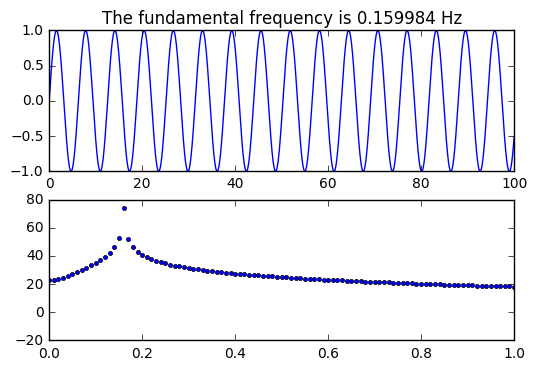

In [331]:
# this is a fun synthetic example of getting frequency from FFT
myf = lambda x: numpy.sin(x)
xmin = 0
xmax = 100
xsteps = 10000
t = numpy.linspace(xmin,xmax,xsteps)
frate = xsteps/(xmax-xmin)

signal = myf(t)
w = abs(numpy.fft.fft(signal))
myfreqs = numpy.fft.fftfreq(w.size,t[1]-t[0])

fig = plt.figure()
ax1 = fig.add_subplot('211')
ax1.plot(t,signal)

ax2 = fig.add_subplot('212')
ax2.plot(myfreqs,20*numpy.log10(w),linestyle='None',marker='o', markersize=3)
ax2.set_xlim(0,1)
ax1.set_title('The fundamental frequency is {} Hz'.format(myfreqs[numpy.argmax(w)]))
plt.show()

In [373]:
# applying the synthetic FFT-to-frequency example to the real data...

def get_freq_fft(myfile,doplot=False):
    data = numpy.genfromtxt(myfile,delimiter=',',usecols=(0,1),
                                names=('Time','Vapp','Vcap','I'),
                            dtype=(float,float,float,float))
    t = data['Time']
    signal = data['Vapp']
    w = abs(numpy.fft.fft(signal))
    myfreqs = numpy.fft.fftfreq(w.size,t[1]-t[0])
    freq = abs(myfreqs[numpy.argmax(w)])
    
    if doplot:
        fig = plt.figure()
        ax1 = fig.add_subplot('211')
        ax1.plot(t,signal)
        ax2 = fig.add_subplot('212')
        ax2.plot(myfreqs,20*numpy.log10(w),linestyle='None',marker='o', markersize=3)
        ax2.set_xlim(0,30000)
        ax2.set_ylim(0,(20*numpy.log10(w)).max()*1.2)
        ax1.set_title('The fundamental frequency is {} Hz'.format(freq))
        plt.show()
    return freq

myfile = os.path.join(dinosc,'2016-07-06_06:39:44')
get_freq_fft(myfile)
%timeit get_freq_fft(os.path.join(dinosc,"2016-07-06_06:39:44"))

100 loops, best of 3: 6.81 ms per loop


In [366]:
def get_freq_file(myfile):
    data = numpy.genfromtxt(myfile,delimiter=',',usecols=(0,1),
                                names=('Time','Vapp','Vcap','I'),
                            dtype=(float,float,float,float))
    xset = data['Time']
    yset = data['Vapp']
    zerocross=[]
    ymax = max(yset)
    ymin = min(yset)
    ymid = (ymax+ymin)/2
    for i in range(2,len(yset)-2):
        if (yset[i] >= ymid) and (yset[i+1] >= ymid) and (yset[i-1] <= ymid) and (yset[i-2] <= ymid):
            thiscross = xset[i]
            zerocross.append(thiscross)
            #print('crossing between indexes {} and {}'.format(i, i+1))
        elif (yset[i] <= ymid) and (yset[i+1] <= ymid) and (yset[i-1] >= ymid) and (yset[i-2] >= ymid):
            thiscross = xset[i]
            zerocross.append(thiscross)
            #print('crossing between indexes {} and {}'.format(i, i+1))
    zerointerval=[]
    for i in range(1,len(zerocross)):
        zerointerval.append(zerocross[i]-zerocross[i-1])
    return (2 / numpy.mean(zerointerval))

%timeit get_freq_file(os.path.join(dinosc,"2016-07-06_06:39:44"))

100 loops, best of 3: 7.09 ms per loop


/home/brandon/.virtualenvs/sci3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


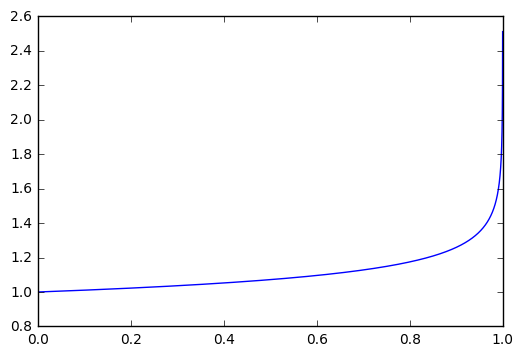

In [391]:
myf = lambda x: (1-x)**-0.1
x = numpy.linspace(0,1,10000)
plt.plot(x,myf(x))
plt.show()

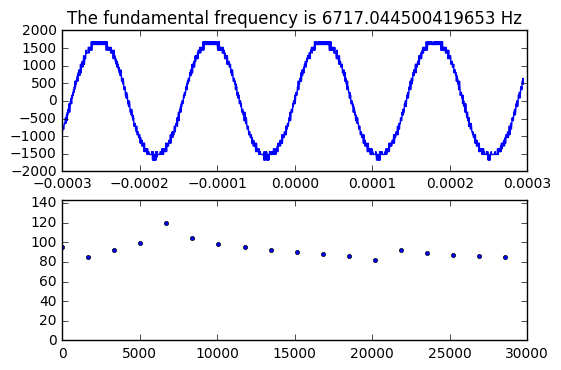

6717.0445004196526

In [389]:
get_freq_fft_file(os.path.join(dinosc,"2016-07-06_06:39:44"),doplot=True)